In [ ]:
# !pip install qamomile[cudaq]

# Using the CUDA-Q Transpiler in Qamomile
This tutorial demonstrates the usage of the CUDA-Q Transpiler in Qamomile and provides key examples to guide users in applying it effectively.

## Translating a Hamiltonian into CUDA-Q

We begin by defining a Hamiltonian as a test example and use our transpiler to convert it into a CUDA-Q-compatible representation. This step shows how seamlessly the Hamiltonian defined in our own library’s format can be translated into operators recognized by CUDA-Q.

In [ ]:
import cudaq
import numpy as np
import qamomile
from qamomile.cudaq.transpiler import CudaqTranspiler
from qamomile.core.operator import Hamiltonian, X, Y, Z
from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.circuit import Parameter

import jijmodeling as jm
import networkx as nx

In this snippet, we start from a custom-defined Hamiltonian using various Pauli operators (X, Y, Z) and then employ `CudaqTranspiler` to convert it into a format directly suitable for CUDA-Q. By inspecting `ops_first_term` and printing out `cudaq_hamiltonian`, we can verify the correctness of the translation.

In [4]:
hamiltonian = Hamiltonian()
hamiltonian += X(0)*Z(1)
hamiltonian += Y(0)*Y(1)*Z(2)*X(3)*X(4)

transpiler = CudaqTranspiler()
cudaq_hamiltonian = transpiler.transpile_hamiltonian(hamiltonian)

print(cudaq_hamiltonian)

(0+0i) + (1+0i) * X0Z1 + (1+0i) * Y0Y1Z2X3X4


## Constructing a Parameterized Quantum Circuit

Next, we build a parameterized quantum circuit using QamomileCircuit. We include single-qubit rotations (e.g., rx, ry, rz) and controlled variants (crx, crz, cry), as well as two-qubit entangling gates (rxx, ryy, rzz). The parameters (theta, beta, gamma) allow for flexible variational adjustments.

In [ ]:
qc = QamomileCircuit(3)
theta = Parameter("theta")
beta = Parameter("beta")
gamma = Parameter("gamma")

qc.rx(theta, 0)
qc.ry(beta, 1)
qc.rz(gamma, 2)
qc.crx(gamma, 0 ,1)
qc.crz(theta, 1 ,2)
qc.cry(beta, 2 ,0)
qc.rxx(gamma, 0 ,1)
qc.ryy(theta, 1 ,2)
qc.rzz(beta, 2 ,0)

transpiler = CudaqTranspiler()
cudaq_qc = transpiler.transpile_circuit(qc)

## Formulating the MaxCut Problem and Converting it into a Quantum Form

In the following part, we demonstrate how to take a classical optimization problem—MaxCut—and encode it into an Ising-form Hamiltonian. We then construct a QAOA-style ansatz circuit that, when executed and optimized, attempts to solve the MaxCut instance.

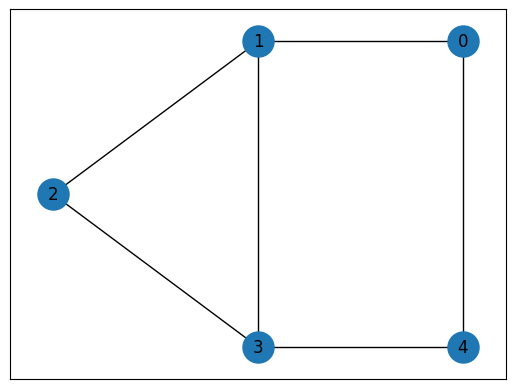

In [6]:
def maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem

def maxcut_instance():
    # Construct a simple graph for a MaxCut instance
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3, 4])
    G.add_edges_from([(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])
    E = [list(edge) for edge in G.edges]
    instance_data = {"V": G.number_of_nodes(), "E": E}
    pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
    nx.draw_networkx(G, pos, node_size=500)
    return instance_data

problem = maxcut_problem()
instance_data = maxcut_instance()
interpreter = jm.Interpreter(instance_data)
compiled_instance = interpreter.eval_problem(problem)

# Convert the compiled problem into a QAOA form.
qaoa_converter = qamomile.core.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode()

p = 5
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

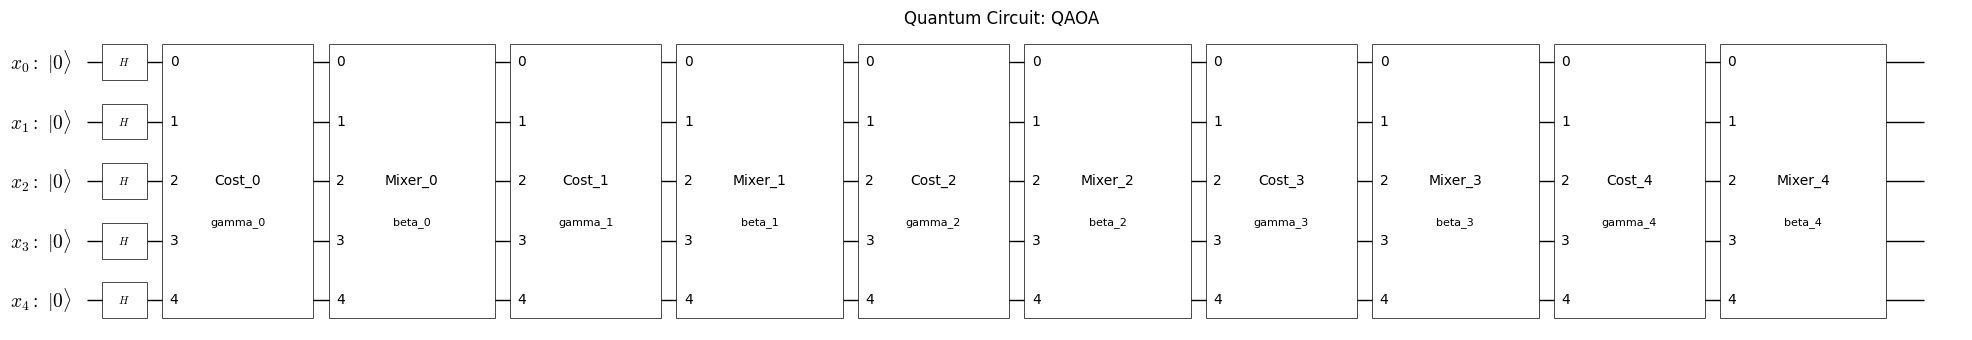

In [7]:
from qamomile.core.circuit.drawer import plot_quantum_circuit

plot_quantum_circuit(qaoa_circuit)

We have now translated the MaxCut problem into a cost Hamiltonian suitable for a QAOA-like algorithm. The parameter `p` determines the number of layers of problem and mixer Hamiltonians. Each layer’s parameters are variational and will be tuned to minimize the expvalue, ideally leading to a good solution to the MaxCut instance.

## Transpiling and Executing the QAOA Circuit in CUDA-Q

With the QAOA circuit and Hamiltonian defined, we use the transpiler again, this time to convert the QAOA circuit and cost Hamiltonian into CUDA-Q forms:

In [8]:
transpiler = CudaqTranspiler()
circ_func = transpiler.transpile_circuit(qaoa_circuit)
cudaq_hamiltonian = transpiler.transpile_hamiltonian(qaoa_hamiltonian)

cost_history = []

def objective(parameters):
    expectation_value = cudaq.observe(circ_func, cudaq_hamiltonian, parameters).expectation()
    cost_history.append(expectation_value)
    return expectation_value

Here, `circ_func` is the PennyLane circuit function generated from the QAOA ansatz. Evaluating `circuit(p)` gives the expectation value of the cost Hamiltonian for the given set of parameters `p`.

## Optimizing the Parameters

Finally, we leverage CUDA-Q’s optimizers to update the parameters and attempt to find those that yield better results (e.g., lower cost for the MaxCut objective):

In [9]:
optimizer = cudaq.optimizers.COBYLA()
num_parameters = len(qaoa_circuit.get_parameters())
initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, num_parameters)
optimizer.initial_parameters = initial_parameters
print("Initial parameters = ", optimizer.initial_parameters)

optimal_expectation, optimal_parameters = optimizer.optimize(dimensions=num_parameters, function=objective)
print("Optimal Parameters")
print(optimal_parameters)

Initial parameters =  [-0.3592987296348616, 0.013051261183044949, 0.32491744400253264, -0.12329265025548464, 0.1116984274445526, -0.34246869847233713, -0.23762749854446114, -0.04400424673470005, -0.04984738129914362, -0.35139414506470906]
Optimal Parameters
[1.6948217996605364, 2.288032487241756, 1.0916896164440923, 0.6461590151377731, 2.4531428322653945, -0.7121704374378344, 1.0619200346348785, 0.7242215081232152, -0.5623247703260246, -0.7761463348056767]


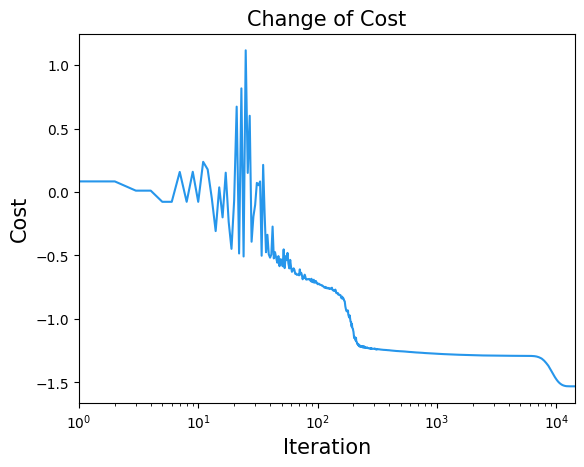

In [10]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, len(cost_history))
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

Once the optimized parameters are obtained, we use `cudaq.sample` to sample from the parameterized quantum circuit to get the circuit counts.

In [12]:
results = cudaq.sample(circ_func, optimal_parameters, shots_count=1000)

## Evaluating the Results
From the `circuit_counts` obtained earlier, we can transfer them to a sampleset by `qaoa_converter.decode`.
The sampleset can select only the feasible solutions and then we examine the distribution of the objective function values.

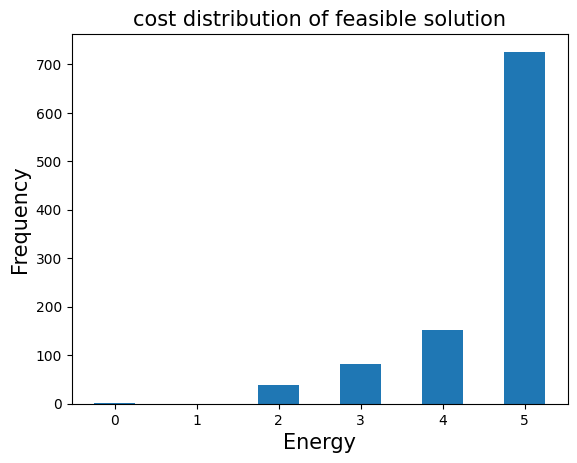

In [17]:
import matplotlib.pyplot as plt

sampleset = qaoa_converter.decode(transpiler, results)
feasible_ids = sampleset.summary.query("feasible == True").index
energies = []
frequencies = []

# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    if sample_id in feasible_ids:
        energy_freq[sample.objective] += 1

energies = list(energy_freq.keys())
frequencies = list(energy_freq.values())

plt.bar(energies, frequencies, width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()